## Embed lung data using trained scVI model

In [59]:
from os.path import join
import pickle
import scanpy as sc
import scvi
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker
# plotting
import seaborn as sns

Set scVI seed

In [33]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.2

Define paths and filenames for reading and writing. Define function for object serialization/deserialization.

In [69]:
# Saves the pickly object to a .pkl file.
def save_object(obj, filepath):
    with open(filepath, 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
# Loads a saved .pkl file.
def load_object(filepath):
    with open(filepath, 'rb') as input:
        obj = pickle.load(input)
    return obj

In [64]:
in_data_dir = "/local/home/savchuki/projects/swarm-atlas/data"
in_data_filename = "lung-atlas-public-processed.h5ad"
in_results_dir = "/local/home/savchuki/projects/swarm-atlas/results"
in_scvi_model_dir = join(in_results_dir, "scvi")
in_scanvi_model_dir = join(in_results_dir, "scanvi")
in_model_filename = "scvi-lung.pt"
in_data_path = join(in_data_dir, in_data_filename)
out_results_dir = "/local/home/savchuki/projects/swarm-atlas/results"
out_analysis_dir = join(out_results_dir, "analysis")
out_figures_dir = join(out_results_dir, "figures")
out_benchmark_obj_name = "scvi-scanvi-pca-benchmarker.pkl"
out_benchmark_path = join(out_analysis_dir, out_benchmark_obj_name)

Set some plot params 

In [21]:
torch.set_float32_matmul_precision("high")

In [35]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [36]:
adata = sc.read(in_data_path)
adata

AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts'

In [41]:
model = scvi.model.SCVI.load(in_scvi_model_dir, adata=adata)
model

Trainer will use only 1 of 6 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=6)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File /local/home/savchuki/projects/swarm-atlas/results/scvi/model.pt already downloaded                   


/home/savchuki/miniconda3/envs/swarm-atlas/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


SCVI model with the following parameters: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [26]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [27]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)

/tmp/ipykernel_2759674/2529970008.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


In [28]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])

Trainer will use only 1 of 6 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=6)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


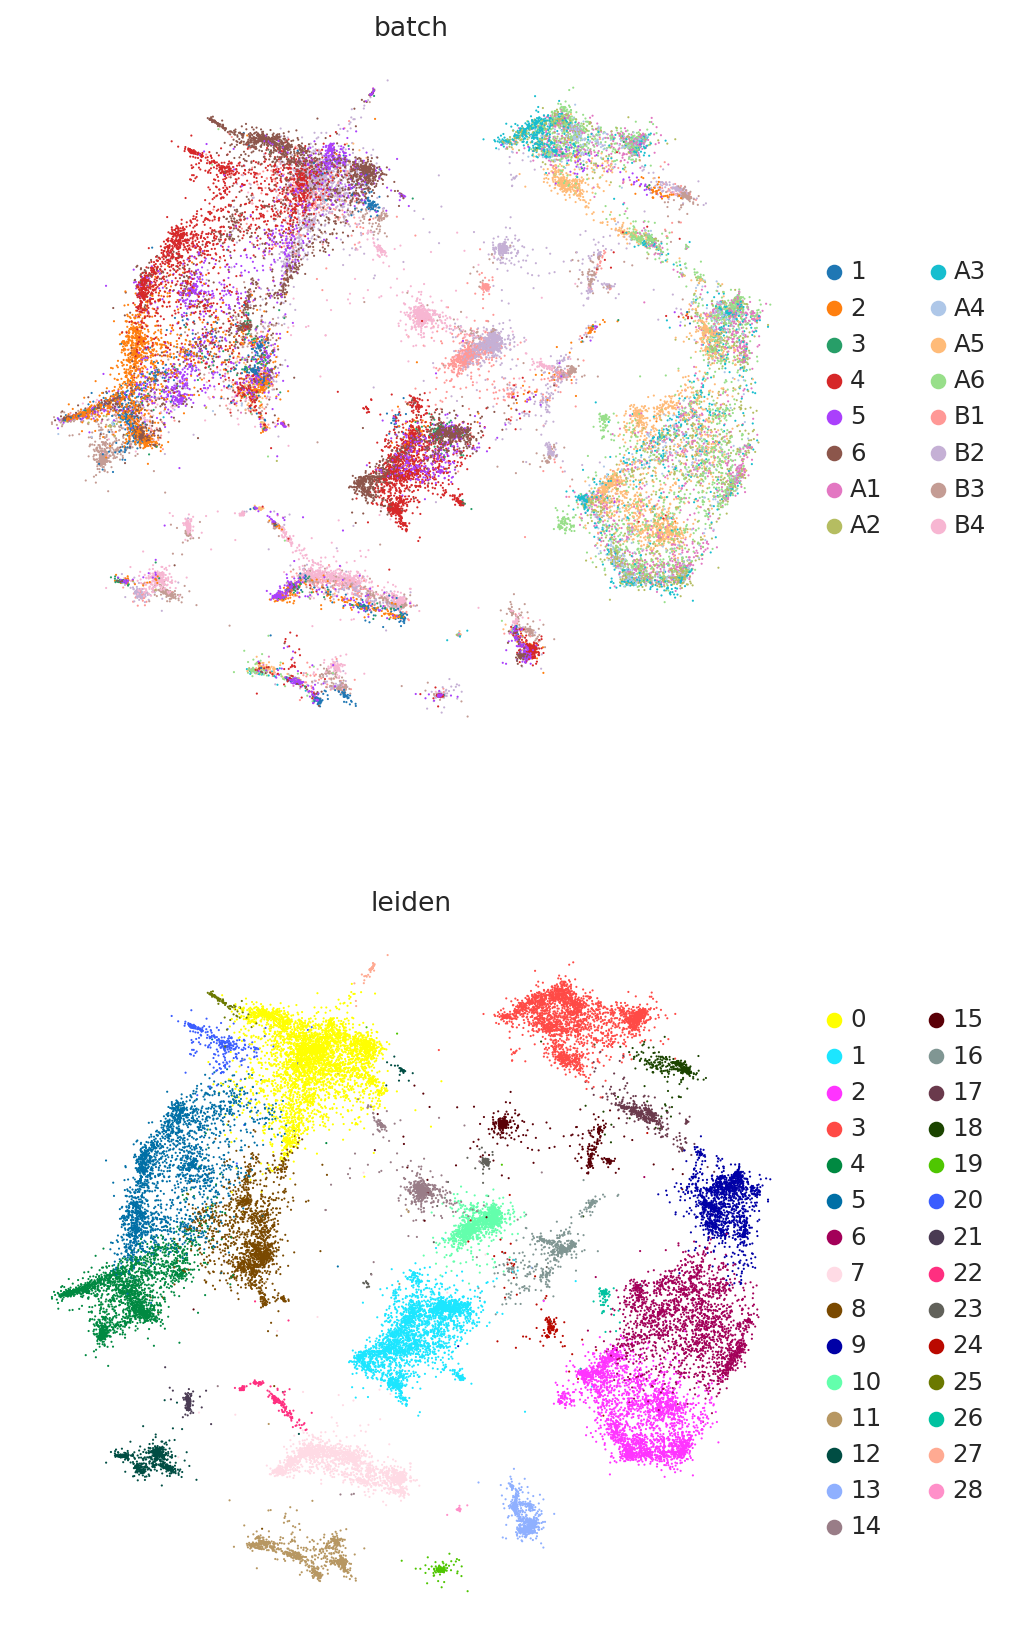

In [29]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["batch", "leiden"],
    frameon=False,
    ncols=1,
)

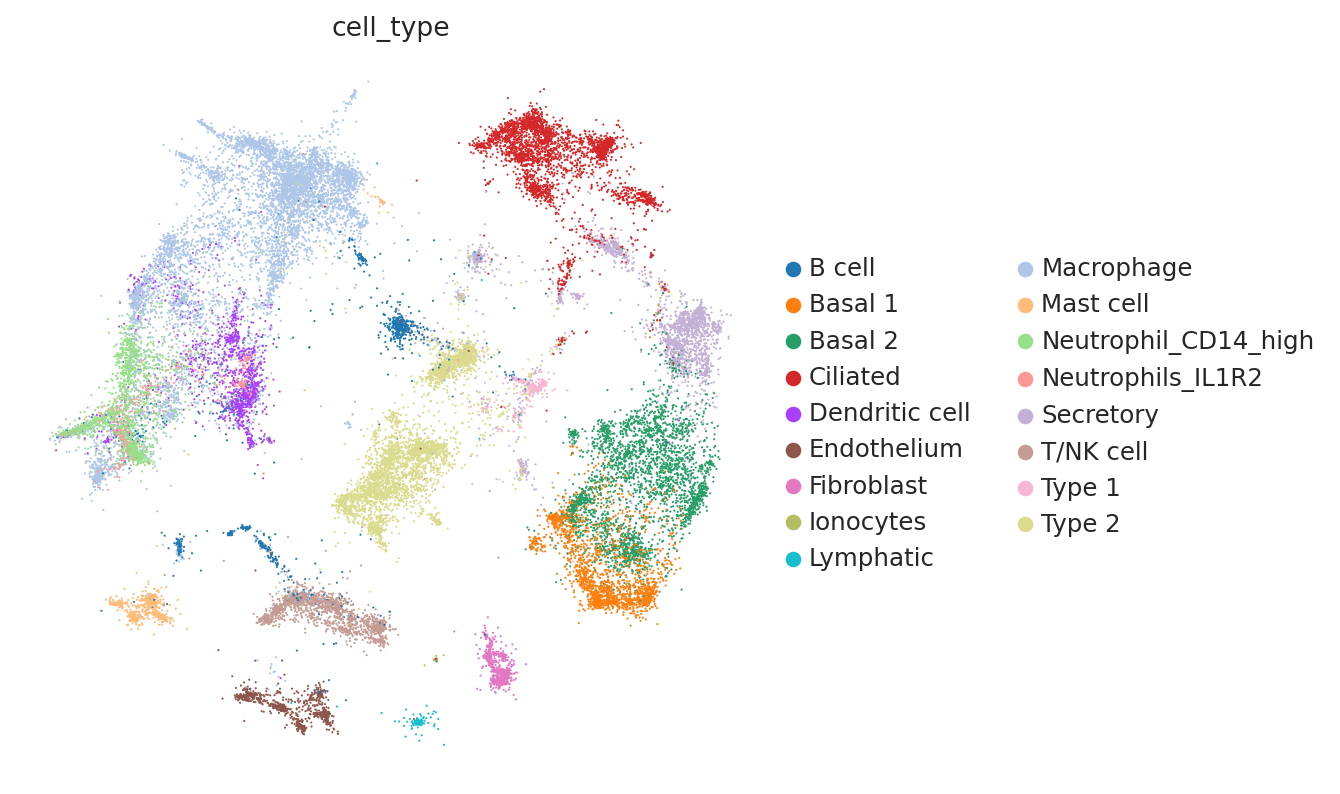

In [30]:
sc.pl.embedding(adata, basis=SCVI_MDE_KEY, color=["cell_type"], frameon=False, ncols=1)

Load trained scANVI model and make embeddings.

In [44]:
scanvi_model = scvi.model.SCANVI.load(in_scanvi_model_dir, adata=adata)

Trainer will use only 1 of 6 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=6)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File /local/home/savchuki/projects/swarm-atlas/results/scanvi/model.pt already downloaded                 


/home/savchuki/miniconda3/envs/swarm-atlas/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [47]:
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)

In [48]:
SCANVI_MDE_KEY = "X_scANVI_MDE"
adata.obsm[SCANVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCANVI_LATENT_KEY])

Trainer will use only 1 of 6 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=6)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


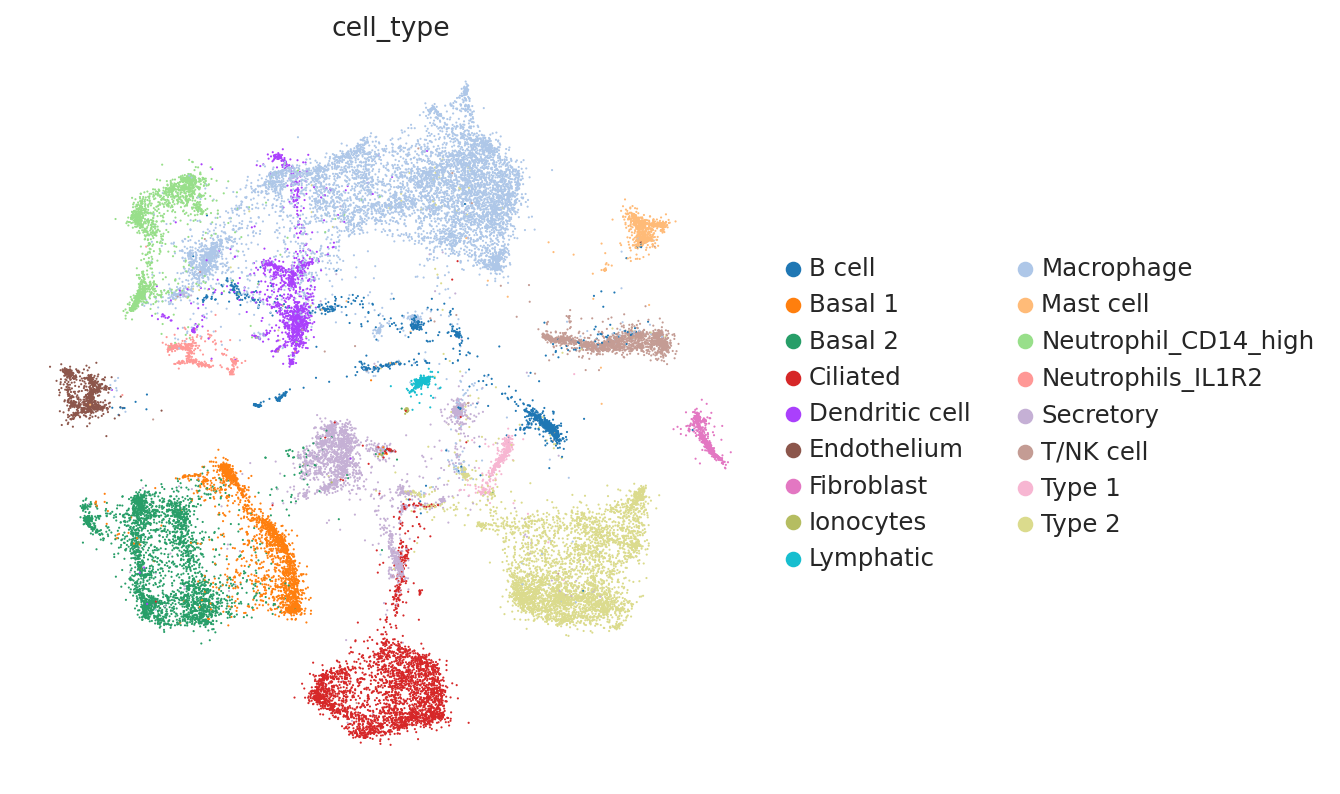

In [49]:
sc.pl.embedding(
    adata, basis=SCANVI_MDE_KEY, color=["cell_type"], ncols=1, frameon=False
)

Compute integration metrics

In [50]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", SCVI_LATENT_KEY, SCANVI_LATENT_KEY],
    n_jobs=-1,
)
bm.benchmark()

/home/savchuki/miniconda3/envs/swarm-atlas/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]/home/savchuki/miniconda3/envs/swarm-atlas/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/savchuki/miniconda3/envs/swarm-atlas/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/savchuki/miniconda3/envs/swarm-atlas/lib/python

Save the benchmarking object as a pickle file.

In [65]:
save_object(bm, out_benchmark_path)

Plot the results table.

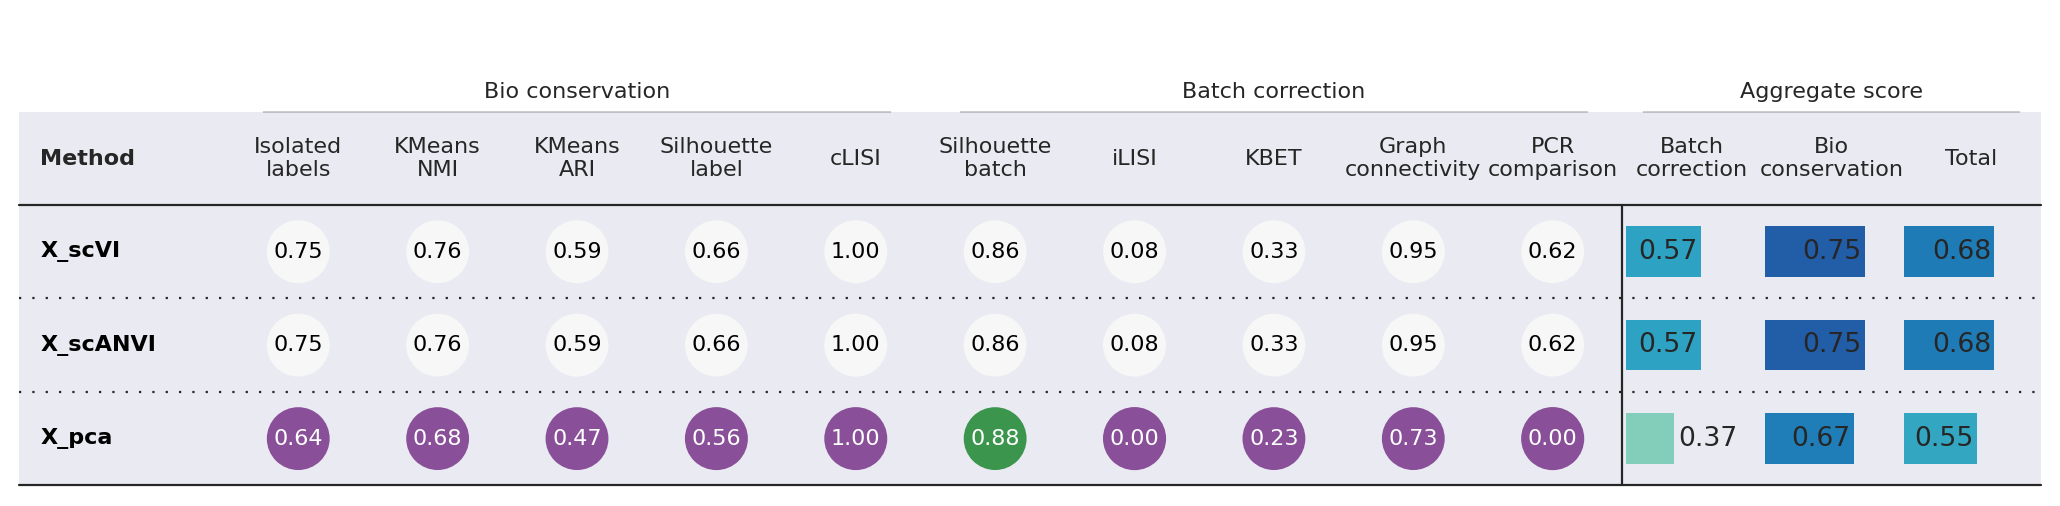

In [56]:
bm.plot_results_table(min_max_scale=False, save_dir=out_figures_dir)

Show the results dataframe.

In [53]:
df = bm.get_results(min_max_scale=False)
print(df)

Isolated labels        KMeans NMI        KMeans ARI  \
Embedding                                                           
X_pca                0.643649          0.681818          0.470351   
X_scVI               0.747119          0.757291           0.59295   
X_scANVI             0.747119          0.757291           0.59295   
Metric Type  Bio conservation  Bio conservation  Bio conservation   

             Silhouette label             cLISI  Silhouette batch  \
Embedding                                                           
X_pca                0.557428               1.0          0.878196   
X_scVI               0.657598               1.0          0.855061   
X_scANVI             0.657598               1.0          0.855061   
Metric Type  Bio conservation  Bio conservation  Batch correction   

                        iLISI              KBET Graph connectivity  \
Embedding                                                            
X_pca                0.003434          0.227728            0.72862   
X_scVI               0.082946          0.330578            0.95493   
X_scANVI             0.082946          0.330578            0.95493   
Metric Type  Batch correction  Batch correction   Batch correction   

               PCR comparison Batch correction Bio conservation  \
Embedding                                                         
X_pca                     0.0         0.367596         0.670649   
X_scVI               0.615196         0.567742         0.750992   
X_scANVI             0.615196         0.567742         0.750992   
Metric Type  Batch correction  Aggregate score  Aggregate score   

                       Total  
Embedding                     
X_pca               0.549428  
X_scVI              0.677692  
X_scANVI            0.677692  
Metric Type  Aggregate score